In [1]:
import os, glob, shutil, sys, copy, time, json, copy, subprocess
from IPython import display
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, img_as_uint, color, transform, exposure
from skimage.filters import threshold_mean, sobel
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows, crop
import imagej
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
import warnings

from acquisitions import *
from image_utils import *

In [2]:
# os.environ['JAVA_MEM'] = '-Xmx4096m'
os.environ['_JAVA_OPTIONS']="-Xmx12g"
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None        

In [3]:
config = {
    ### user configuration        
    "lsm-resolution" : 256, # 256, 512, 1024
    "lsm-bin-factor" : 3,
    "lsm-scan-rate" : '400000.0000',
    "lsm-pc-power" : 0.4, # 1
    "lsm-pmt-gain" : 0.4,
    
    ### hard configuration
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg-base" : 0.509, # 0.509 micron/pixel at 256
    "pixel-size-shg" : 0.509,
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),
    "slide-size" : (38000.0, 18000.0), # (width, height) (70000, -20000)
    "slide-start" : (0, 0), # x, y
    "Z-stage-20x" : -6930, # -6930 + 290
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15000, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-2000.0, 40000.0),
    "hard-limit-y" : (-2000, 20000.0),
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-600, 10), # 4x + this value to 20x // (-590, 74)
    "shg-offset" : (-580, -280), # 4x + this value to shg // (-580, -172)
    "led-4x" : 4,
    "led-20x" : 5,
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
    
    ### configuration group
    "exposure-level" : "mid",
    "snr-level" : "low",
}
# 4x position list is in row x column x z (generate by generate_grid function), 20x and shg position lists are in pos i z, order is x, y

def config_sys(config):
    if config["exposure-level"]=="mid":
        config["lsm-scan-rate"] = '400000.0000'
        config["lsm-pc-power"] = 0.4
        config["lsm-pmt-gain"] = 0.4
    if config["exposure-level"]=="low":
        config["lsm-scan-rate"] = '500000.0000'
        config["lsm-pc-power"] = 0.3
        config["lsm-pmt-gain"] = 0.35
    if config["exposure-level"]=="high":
        config["lsm-scan-rate"] = '200000.0000'
        config["lsm-pc-power"] = 0.45
        config["lsm-pmt-gain"] = 0.42
    return config

In [4]:
config = config_sys(config)

In [6]:
def whole_slide_scan(config, core=None, save_path=None, acq_name=None, position_list=None, mag='4x', mda=False, z_stack=False, z_center=None, sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if position_list.shape[1] == 3:
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
            if z_stack:
                with Acquisition(save_path, acq_name, lsm_process_fn(config)) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_center is None:
                z_center = config["Z-stage-laser"]
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
#         search_range_base = 1000
        redive_flag = True
        bg_flag = False
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        if position_list.shape[1] == 3:
            tile_count = 0
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            core.set_focus_device(config["focus-device"])                
#             position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2).reshape(position_list.shape[0], 3)
#             position_list = position_list.reshape(position_list.shape[0]*position_list.shape[1], position_list.shape[2])
            for pos in range(position_list.shape[0]):
                z_pos = position_list[pos, 2]
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                    or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                    print('position out of range')
                    break
                core.set_position(z_pos)
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.wait_for_device(xy_device)
                core.wait_for_device(z_device)
                if focus_dive and mag=='4x':
                    if redive_flag:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=1000, steps=5, snap=False)
                        if not bg_flag:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=200, steps=5, snap=True)
                    else:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=200, steps=5, snap=True)
                    z_positions[pos] = pos_z
                if focus_dive and mag=='20x':
#                     if redive_flag:
                    if True:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=150, steps=5, check_background=True, snap=False)
                        if not bg_flag:
                            pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=False, snap=False)
                            pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=5, steps=5, check_background=False, snap=True)
#                     else:
#                         pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=True, snap=False)
#                         pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=5, steps=5, check_background=False, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False  
                if background_image is not None:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
                    
        if position_list.shape[1] == 2:
            tile_count = 0
#             core.set_focus_device(config["focus-device"])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
#             position_list = position_list.reshape(position_list.shape[0], position_list.shape[1], 2)
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                    print('position out of range')
                    break
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                core.wait_for_device(xy_device)
                if focus_dive and mag=='4x':
                    if redive_flag:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=1000, steps=5, snap=False)
                        if not bg_flag:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=250, steps=5, snap=True)
                    else:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=500, steps=5, snap=True)
                    z_positions[pos] = pos_z
                if focus_dive and mag=='20x':
#                     if redive_flag:
                    if True:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=150, steps=5, check_background=True, snap=False)
                        if not bg_flag:
                            pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=False, snap=False)
                            pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=5, steps=5, check_background=False, snap=True)
#                     else:
#                         pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=True, snap=False)
#                         pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=5, steps=5, check_background=False, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False                
                if background_image is not None:
                    pixels = white_balance(config, pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}.tiff'.format(pos), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            returns.append((sum_img / sum_count))
            io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(np.squeeze(sum_img / sum_count)))
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], 1)
            returns.append(z_positions)
        return tuple(returns)

In [7]:
def autofocus(config, core, method='edge', mag='4x', rgb=True, search_range=45, steps=5, snap=True, crop_ratio=1.0, flip_channel=True, check_background=True, offset=0):
    if mag=='4x':
        drift_limit = config["Z-stage-4x"]
    if mag=='20x':
        drift_limit = config["Z-stage-20x"]
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = search_range/steps
    scores = []
    positions = []
    count = 0
    for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
        position_z = step * interval_z + current_z
        if position_z < config["hard-limit-z"][0] or position_z > config["hard-limit-z"][1]:
            print("z-stage out of range, new focus discarded")
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if check_background and step==-int(np.floor(steps/2)):
            bg_flag = is_background(pixels)
            if bg_flag:
                core.set_position(current_z)
                core.wait_for_system()
                print("Is background")
                return current_z, pixels, bg_flag
        img_gray = color.rgb2gray(pixels)
        print("\n Diving focus at " + str(step))
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        if method == 'edge':
            score = np.mean(sobel(img_gray))
#         print(str(score) + " " + str(position_z))
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions) 
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    if focus_z < config["hard-limit-z"][0] or focus_z > config["hard-limit-z"][1]:
        print("z-stage out of range, new focus discarded")
        focus_z = position_z
    if np.abs(focus_z-drift_limit) > 1000:
        print("z-stage out of range, reset focus")
        focus_z = drift_limit
        core.set_position(drift_limit)
        core.wait_for_system()
    else:
        core.set_position(focus_z)
        core.wait_for_system()
    if snap:
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        return focus_z+offset, pixels, False
    else:
        return focus_z+offset, None, False

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        core.wait_for_system()
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        core.wait_for_system()
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    return position_list_z

In [9]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()

In [10]:
ij = imagej.init('fiji\\fiji\\Fiji.app')

In [11]:
core.set_timeout_ms(20000)

In [12]:
switch_objective(config, core, '4x')
switch_mod(config, core, mod='bf')

KeyboardInterrupt: 

In [11]:
save_path = 'data/acquisition'
acq_name = 'PA-2072-4x-v1'

In [12]:
# position_list, grid = generate_grid(config, mag='4x', box=(5000, 5000, 20000, 15000))
position_list = generate_grid(config, mag='4x')
position_list.shape

(17, 26, 2)

In [13]:
position_list

array([[[    0.  ,     0.  ],
        [ 1482.91,     0.  ],
        [ 2965.82,     0.  ],
        [ 4448.73,     0.  ],
        [ 5931.64,     0.  ],
        [ 7414.55,     0.  ],
        [ 8897.46,     0.  ],
        [10380.37,     0.  ],
        [11863.28,     0.  ],
        [13346.19,     0.  ],
        [14829.1 ,     0.  ],
        [16312.01,     0.  ],
        [17794.92,     0.  ],
        [19277.83,     0.  ],
        [20760.74,     0.  ],
        [22243.65,     0.  ],
        [23726.56,     0.  ],
        [25209.47,     0.  ],
        [26692.38,     0.  ],
        [28175.29,     0.  ],
        [29658.2 ,     0.  ],
        [31141.11,     0.  ],
        [32624.02,     0.  ],
        [34106.93,     0.  ],
        [35589.84,     0.  ],
        [37072.75,     0.  ]],

       [[    0.  ,  1093.95],
        [ 1482.91,  1093.95],
        [ 2965.82,  1093.95],
        [ 4448.73,  1093.95],
        [ 5931.64,  1093.95],
        [ 7414.55,  1093.95],
        [ 8897.46,  1093.95],
        

 Processing tiles: 442/442
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-4x-v1\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (109 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-4x-v1\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (106 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Docume

exporting slides, please wait...


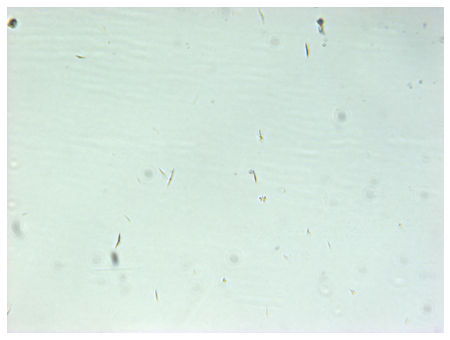

In [50]:
returns = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=False, estimate_background=True, focus_dive=True)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=True, background_image=returns[0])
export_slide(mag='4x')
pd_arr = pd.DataFrame(returns[1])
pd_arr.to_csv(os.path.join(save_path, acq_name+'-z_pos.csv'), index=False)
pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name+'-z_pos.csv'))
z_pos_4x = np.array(pd_arr_r)

 Processing tiles: 147/147
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-20x-v3\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (101 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\BBS-14011-20x-v3\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (96 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\D

exporting slides, please wait...


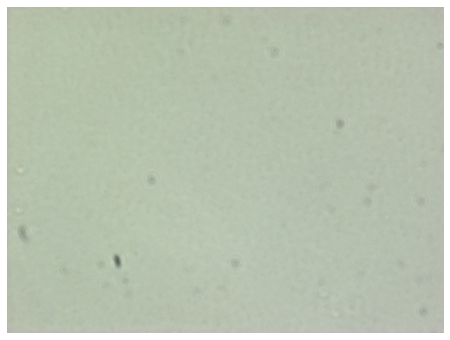

In [29]:
### test 20x only
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
position_list_z = returns[1]
acq_name = 'BBS-14011-4x-v3'
position_lists_20x = annotations_positionlist(config, image_name=acq_name, out_mag='20x')
position_list_20x = position_lists_20x[0]
position_list_xyz = np.concatenate((position_list, position_list_z.reshape((position_list.shape[0], position_list.shape[1], 1))), 2)
sampled_pos_xyz = resample_z_pos(config, mag='20x', xy_pos=position_list_20x, xyz_pos_list_4x=position_list_xyz)
acq_name = 'BBS-14011-20x-v3'
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=True, focus_dive=True)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=True, background_image=returns_20x[0])
export_slide(mag='20x')

In [30]:
### test shg only
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
position_list_z = returns[1]
acq_name = 'BBS-14011-4x-v3'
position_lists_mp = annotations_positionlist(config, image_name=acq_name, out_mag='mp')
position_lists_mp = position_lists_mp[0]
position_list_xyz_20x = np.concatenate((position_list_20x, returns_20x[-1].reshape((returns_20x[-1].shape[0], 1))), 1)
sampled_pos_xyz_mp = resample_z_pos(config, mag='mp', xy_pos=position_lists_mp, xyz_pos_list_20x=position_list_xyz_20x)
acq_name = 'BBS-14011-4-mp-v3-0'
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=sampled_pos_xyz_mp, mda=True, z_stack=True, sample_depth=36, z_step=6, estimate_background=False, focus_dive=False)
stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='mp', mda=True, z_stack=True, position_list=sampled_pos_xyz_mp, flip_y=False, rotate=270, correction=True)
export_slide(mag='mp')

['qupath-projects\\mp-tiles\\BBS-14011-4x-v30.csv']
Imaging mode set as SHG
Dataset opened                 
 Processing tiles: 142/663

ValueError: need at least one array to stack

In [ ]:
# batch 20x acquisition
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
save_path = 'data/acquisition'
acq_name = 'PA-2072-4x-v1'
pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name+'-z_pos.csv'))
z_pos_4x = np.array(pd_arr_r)
position_list_z = z_pos_4x
position_list = generate_grid(config, mag='4x')
position_list_xyz = np.concatenate((position_list, position_list_z.reshape((position_list.shape[0], position_list.shape[1], 1))), 2)
position_lists_20x, annotation_names = annotations_positionlist(config, image_name=acq_name, out_mag='20x')
return_20x_list = []
for idx, roi in enumerate(position_lists_20x):
#     if idx <=7:
#         return_20x_list.append(None)
#         continue
    acq_name = 'PA-2072-20x-v1' + annotation_names[idx]
    sampled_pos_xyz = resample_z_pos(config, mag='20x', xy_pos=roi, xyz_pos_list_4x=position_list_xyz)
    if idx==0:
        returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=True, focus_dive=True)
        stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=True, background_image=returns_20x[0])
        bg_img = returns_20x[0]
    else:
        returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=False, background_image=bg_img, focus_dive=True)
        stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=False)
    export_slide(mag='20x', remove_file=True)
    return_20x_list.append(returns_20x[-1]) ### store focus map
    np.save(os.path.join(save_path, 'PA-2072-'+'20x'+'-z_pos.npy'), return_20x_list, allow_pickle=True)
    print('Object: {}/{}'.format(idx+1, len(position_lists_20x)))

In [ ]:
# batch shg acquisition
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
save_path = 'data/acquisition'
acq_name = 'PA-2072-4x-v1'
position_lists_mp, annotation_mp = annotations_positionlist(config, image_name=acq_name, out_mag='mp')
position_lists_20x, annotation_names = annotations_positionlist(config, image_name=acq_name, out_mag='20x')
return_20x_list = np.load(os.path.join(save_path, 'PA-2072-'+'20x'+'-z_pos.npy'), allow_pickle=True).tolist()
for idx, roi in enumerate(position_lists_mp):
    if idx <=53:
        continue
#     if annotation_mp[idx] != annotation_names[idx]:
#         print('\n Unmatched annotation! \n')
    acq_name = 'PA-2072-lsm-v1' + annotation_mp[idx]
    position_list_z_20x = return_20x_list[idx]
    position_list_xyz_20x = np.concatenate((position_lists_20x[idx], position_list_z_20x.reshape((position_list_z_20x.shape[0], 1))), 1)
    sampled_pos_xyz_mp = resample_z_pos(config, mag='mp', xy_pos=roi, xyz_pos_list_20x=position_list_xyz_20x)
    whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name, position_list=sampled_pos_xyz_mp, mda=True, z_stack=True, sample_depth=24, z_step=6, estimate_background=False, focus_dive=False)
    stitching(config, ij, save_path=save_path, acq_name=acq_name, mag='mp', mda=True, z_stack=True, position_list=sampled_pos_xyz_mp, flip_y=False, rotate=270, correction=None)
    export_slide(mag='mp')

Imaging mode set as SHG
Dataset opened                 
 Processing tiles: 109/109
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-15\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-15\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x5px, channels=1, timepoints=1 (827 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] L

exporting slides, please wait...
Dataset opened                 
 Processing tiles: 109/109
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-16\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-16\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x5px, channels=1, timepoints=1 (301 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] L

exporting slides, please wait...
Dataset opened                 
 Processing tiles: 109/109
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-2\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-2\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x5px, channels=1, timepoints=1 (194 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loa

exporting slides, please wait...
Dataset opened                 
 Processing tiles: 109/109
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-3\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PA-2072-lsm-v1-D-3\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x5px, channels=1, timepoints=1 (57 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Load

exporting slides, please wait...


In [12]:
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')

Imaging mode set as Brightfield
